In [1]:
from datasets import Dataset
from PIL import Image
import json
import os
import supervision as sv

In [2]:
ds_path = r"C:\Users\isaac\dev\CV_Garbage_Detection\Data"

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "train"),
    annotations_path=os.path.join(ds_path, "train", "_annotations.coco.json"),
)

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "test"),
    annotations_path=os.path.join(ds_path, "test", "_annotations.coco.json"),
)

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "valid"),
    annotations_path=os.path.join(ds_path, "valid", "_annotations.coco.json"),
)

In [3]:
def sv_to_custom_format(sv_dataset, class_mapping=None):    
    images, image_ids, widths, heights, objects = [], [], [], [], []  
    image_id = 0
    
    for path, _, detections in sv_dataset:
        # Load image
        img = Image.open(path)
        images.append(img)
        
        # Get image id
        image_ids.append(image_id)
        
        # Get image dimensions
        width, height = img.size
        widths.append(width)
        heights.append(height)
        
        
        # Extract object information
        object_ids, bboxes, areas, categories = [], [], [], []

        for detection in detections:
            x_min, y_min, x_max, y_max = detection[0]  # Supervision bounding box
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
            area = (x_max - x_min) * (y_max - y_min)  # Compute area
            category = class_mapping[detection[3]] if class_mapping else str(detection[3])
            object_ids.append(detection[3])

            bboxes.append(bbox)
            areas.append(area)
            categories.append(category)

        objects.append({
            "id": object_ids,
            "bbox": bboxes,
            "area": areas,
            "category": categories
        })
        
        image_id += 1

    formatted_data = {
        "image": images,
        "image_id": image_ids,
        "width": widths,
        "height": heights,
        "objects": objects
    }
    return formatted_data

def get_class_mappings_from_coco(annotation_path):
    with open(annotation_path, "r") as f:
        coco_data = json.load(f)
    
    # Extract categories
    categories = coco_data["categories"]
    class_mapping = {category["id"]: category["name"] for category in categories}
    return class_mapping

In [4]:
class_mappings = get_class_mappings_from_coco(os.path.join(ds_path, "train", "_annotations.coco.json"))

label2id = {v: k for k, v in class_mappings.items()}
id2label = {k: v for k, v in class_mappings.items()}

formatted_train = sv_to_custom_format(ds_train, class_mappings)
formatted_test = sv_to_custom_format(ds_test, class_mappings)
formatted_valid = sv_to_custom_format(ds_valid, class_mappings)

In [5]:
train_dataset = Dataset.from_dict(formatted_train)
test_dataset = Dataset.from_dict(formatted_test)
valid_dataset = Dataset.from_dict(formatted_valid)

In [6]:
print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"Valid dataset: {len(valid_dataset)} images")

Train dataset: 4200 images
Test dataset: 100 images
Valid dataset: 1704 images


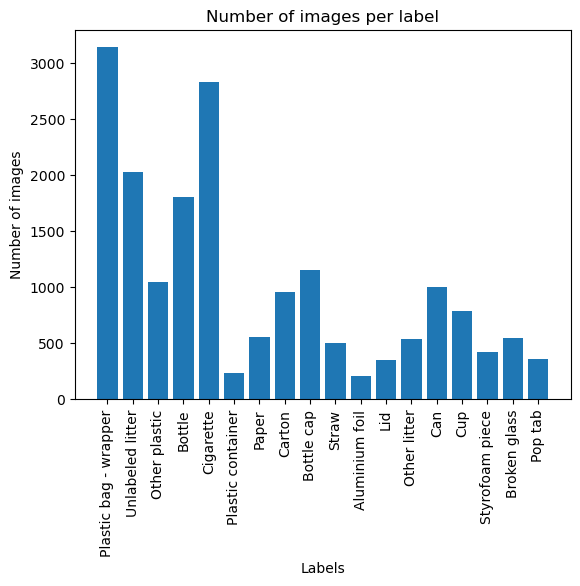

In [63]:
# given all the images/lables is would like to create a table of all the labels and the number of images that contain that label

# create a dictionary of all the labels
labels = {}
for image in train_dataset:
    for label in image["objects"]["category"]:
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1

for image in test_dataset:
    for label in image["objects"]["category"]:
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1

for image in valid_dataset:
    for label in image["objects"]["category"]:
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1
            
# I would like to plot the labels and the number of images that contain that label
import matplotlib.pyplot as plt

plt.bar(labels.keys(), labels.values())
plt.xticks(rotation=90)
plt.xlabel("Labels")
plt.ylabel("Number of images")
plt.title("Number of images per label")
plt.show()


In [47]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor, pipeline
import torch
from PIL import ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
model = AutoModelForObjectDetection.from_pretrained(r"C:\Users\isaac\dev\CV_Garbage_Detection\Models\conditional-detr-resnet-50-finetuned-v2")
processor = AutoImageProcessor.from_pretrained(r"C:\Users\isaac\dev\CV_Garbage_Detection\Models\conditional-detr-resnet-50-finetuned-v2")

In [29]:
obj = pipeline("object-detection", model=model, image_processor=processor,device=0)

In [49]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image

def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

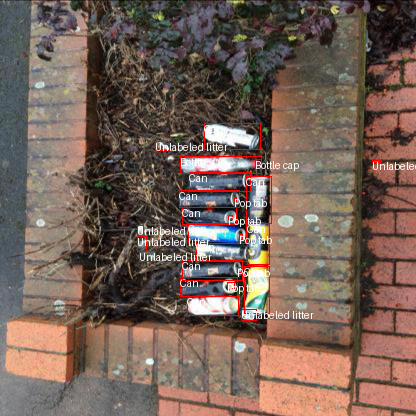

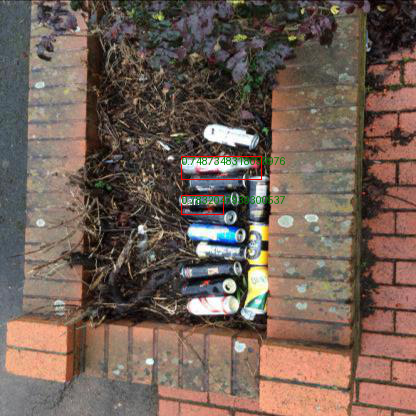

In [60]:
# create a side by side comparison of the image and the predicted bounding boxes
idx = 6

im = test_dataset[idx]["image"]

# get the predicted bounding boxes
pred = obj(im)

gt = draw_image_from_idx(test_dataset, idx)
pred = plot_results(im, pred)

# display the images side by side
display(gt, pred)



In [10]:
import json

all_predictions = []

for item in test_dataset:
    image = item["image"]  
    image_id = item["image_id"]         
    outputs = obj(image)
    for output in outputs:
        box = output["box"]
        x_min, y_min, x_max, y_max = box.values()
        all_predictions.append({
            "image_id": image_id,
            "category_id": label2id[output["label"]],
            "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
            "score": output["score"]
        })
        
with open("predictions.json", "w") as f:
    json.dump(all_predictions, f, indent=4)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [11]:
coco_gt = COCO(os.path.join(ds_path, "test", "_annotations.coco.json"))
coco_dt = coco_gt.loadRes("predictions.json")

coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [12]:
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [13]:
# Average Precision (AP) and Average Recall (AR)
ap = coco_eval.stats[0]  # AP@[IoU=0.50:0.95]
ar = coco_eval.stats[8]  # AR@[IoU=0.50:0.95]

print(f"Average Precision (AP): {ap:.4f}")
print(f"Average Recall (AR): {ar:.4f}")

Average Precision (AP): 0.2343
Average Recall (AR): 0.2695


In [30]:
gt_boxes = []
gt_labels = []
pred_boxes = []
pred_scores = []
pred_labels = []

for item in test_dataset:
    image = item["image"]  
    bboxes = item["objects"]["bbox"]
    labels = item["objects"]["id"]

    for bbox, label in zip(bboxes, labels):
        gt_boxes.append(bbox)
        gt_labels.append(label)
        
    outputs = obj(image)
    
    for output in outputs:
        box = output["box"]
        x_min, y_min, x_max, y_max = box.values()
        pred_boxes.append([x_min, y_min, x_max, y_max])
        pred_scores.append(output["score"])
        pred_labels.append(label2id[output["label"]])
    